In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import aim" || pip install -q aim
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 816 kB 8.0 MB/s 
     |████████████████████████████████| 251 kB 74.4 MB/s 
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'aim'
     |████████████████████████████████| 3.5 MB 5.1 MB/s 
     |████████████████████████████████| 280 kB 58.5 MB/s 
     |████████████████████████████████| 210 kB 60.6 MB/s 
     |████████████████████████████████| 4.3 MB 33.6 MB/s 
     |████████████████████████████████| 5.1 MB 36.3 MB/s 
     |████████████████████████████████| 4.0 MB 56.1 MB/s 
     |████████████████████████████████| 17.2 MB 600 kB/s 
     |████████████████████████████████| 51 kB 395 kB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 4.0 MB 42.0 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████

In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd, 
    EnsureTyped,
    EnsureType,
    Invertd
)

from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import aim
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

In [15]:
import nibabel as nib
import numpy as np
from tqdm.notebook import tqdm

In [3]:
# os.makedirs("./data")
root_dir = "./data/"

In [4]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [00:31, 51.9MB/s]                            

2022-05-14 11:12:57,452 - INFO - Downloaded: data/Task09_Spleen.tar


2022-05-14 11:13:00,402 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2022-05-14 11:13:00,407 - INFO - Writing into directory: ./data/.


In [6]:
eg_img_1 = nib.load("/content/data/Task09_Spleen/imagesTr/spleen_10.nii.gz")
eg_img_2 = nib.load("/content/data/Task09_Spleen/imagesTr/spleen_24.nii.gz")

In [11]:
eg_img_1_data = eg_img_1.get_fdata()
eg_img_2_data = eg_img_2.get_fdata()

In [12]:
print(eg_img_1_data.shape)
print(eg_img_2_data.shape)

(512, 512, 55)
(512, 512, 94)


In [13]:
print(np.max(eg_img_1_data))
print(np.min(eg_img_1_data))

3072.0
-1024.0


In [14]:
print(nib.aff2axcodes(eg_img_1.affine))

('R', 'A', 'S')


In [15]:
eg_img_1.header.get_zooms()

(0.976562, 0.976562, 5.0)

In [5]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))

In [6]:
data_dicts = [{"images": images_name, "labels": label_name} for images_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

set_determinism(seed = 0)

In [7]:
train_transforms = Compose(
    [
     LoadImaged(keys=['images', 'labels']),
     EnsureChannelFirstd(keys = ["images", "labels"]),
     Orientationd(keys=['images', 'labels'], axcodes = 'RAS'),
     Spacingd(keys=['images', 'labels'], pixdim = (1.5,1.5,2), mode = ("bilinear", 'nearest')),
     ScaleIntensityRanged(
            keys=["images"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
     CropForegroundd(keys=['images', 'labels'], source_key="images"),
     RandCropByPosNegLabeld(
            keys=['images', 'labels'],
            label_key="labels",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="images",
            image_threshold=0,
        ),
     EnsureTyped(keys=['images', 'labels']),     
          
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["images", "labels"]),
        EnsureChannelFirstd(keys=["images", "labels"]),
        Orientationd(keys=["images", "labels"], axcodes="RAS"),
        Spacingd(keys=["images", "labels"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["images"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["images", "labels"], source_key="images"),
        EnsureTyped(keys=["images", "labels"]),
    ]
)


In [8]:
check_ds = Dataset(data = val_files, transform = val_transforms)
check_loader = DataLoader(check_ds, batch_size = 1)
check_data = first(check_loader)
img, label = check_data['images'], check_data['labels']

In [20]:
img.shape

torch.Size([1, 1, 226, 157, 113])

In [21]:
check_ds = Dataset(data = train_files, transform = train_transforms)
check_loader = DataLoader(check_ds, batch_size = 1)
check_data = first(check_loader)
img, label = check_data['images'], check_data['labels']

In [22]:
img.shape

torch.Size([4, 1, 96, 96, 96])

In [23]:
np.unique(label)

array([0., 1.], dtype=float32)

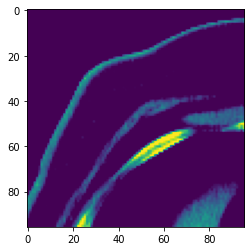

In [24]:
plt.imshow(img[2,0,:,:,56])

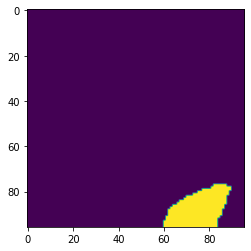

In [25]:
plt.imshow(label[2,0,:,:,56])

In [9]:
train_ds = CacheDataset(
    data = train_files, transform = train_transforms,
    cache_rate = 1.0, num_workers = 2
)

train_loader = DataLoader(train_ds, batch_size = 2, shuffle = True, num_workers=2)
val_ds = CacheDataset(
    data = val_files, transform = val_transforms,
    cache_rate = 1.0, num_workers = 2
)
val_loader = DataLoader(val_ds, batch_size = 1, shuffle = False, num_workers=2)

Loading dataset: 100%|██████████| 9/9 [00:17<00:00,  1.94s/it]


In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 
# model = UNet(spatial_dims=3,
#              in_channels=1, 
#              out_channels=2,
#              channels = (16,32,64,128,256),
#              strides = (2,2,2,2),
#              num_res_units = 2,
#              norm = Norm.BATCH
#              ).to(device)        

UNet_meatdata = dict(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH
)

model = UNet(**UNet_meatdata).to(device)


In [12]:
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
loss_type = "DiceLoss"
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")


In [13]:
Optimizer_metadata = {}
for ind, param_group in enumerate(optimizer.param_groups):
    optim_meta_keys = list(param_group.keys())
    Optimizer_metadata[f'param_group_{ind}'] = {key: value for (key, value) in param_group.items() if 'params' not in key}

In [ ]:
max_epochs = 600
val_interval = 10
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

# initialize a new Aim Run
aim_run = aim.Run()
# log model metadata
aim_run['UNet_meatdata'] = UNet_meatdata
# log optimizer metadata
aim_run['Optimizer_metadata'] = Optimizer_metadata


slice_to_track = 80

for epoch in tqdm(range(max_epochs)):
  model.train()
  epoch_loss = 0
  step = 0
  for batch_data in train_loader:
    step += 1
    inputs, labels = (
        batch_data['images'].to(device),
        batch_data['labels'].to(device)
    )
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()
    epoch_loss +=loss.item()
    print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    aim_run.track(loss.item(), name="batch_loss", context={'type':loss_type})

  epoch_loss /= step
  epoch_loss_values.append(epoch_loss)
  aim_run.track(epoch_loss, name="epoch_loss", context={'type':loss_type})

  print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

  if (epoch + 1) % val_interval == 0:

    model.eval()
    with torch.no_grad():
      for index, val_data in enumerate(val_loader):
        val_inputs, val_labels = val_data['images'], val_data['labels']
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
        
        output = torch.argmax(val_outputs, dim=1)[0, :, :, slice_to_track].float()

        aim_run.track(aim.Image(val_inputs[0, 0, :, :, slice_to_track], \
                                        caption=f'Input Image: {index}'), \
                               name='validation', context={'type':'input'})
        aim_run.track(aim.Image(val_labels[0, 0, :, :, slice_to_track], \
                                caption=f'Label Image: {index}'), \
                        name='validation', context={'type':'label'})
        aim_run.track(aim.Image(output, caption=f'Predicted Label: {index}'), \
                        name = 'predictions', context={'type':'labels'})
                      
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]

        metric = dice_metric.aggregate().item()
        aim_run.track(metric, name="val_metric", context={'type':loss_type})
        dice_metric.reset()

        metric_values.append(metric)
        if metric > best_metric:
          best_metric = metric
          best_metric_epoch = epoch + 1
          torch.save(model.state_dict(), os.path.join(
              root_dir, "best_metric_model.pth"))
          
          best_model_log_message = f"saved new best metric model at the {epoch+1}th epoch"
          aim_run.track(aim.Text(best_model_log_message), name='best_model_log_message', epoch=epoch+1)
          print(best_model_log_message)
                
          message1 = f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
          message2 = f"\nbest mean dice: {best_metric:.4f} "
          message3 = f"at epoch: {best_metric_epoch}"
    
          aim_run.track(aim.Text(message1 +"\n" + message2 + message3), name='epoch_summary', epoch=epoch+1)
          print(message1, message2, message3)










        





      





  0%|          | 0/600 [00:00<?, ?it/s]

1/16, train_loss: 0.6764
2/16, train_loss: 0.6668
3/16, train_loss: 0.6625
4/16, train_loss: 0.6608
5/16, train_loss: 0.6687
6/16, train_loss: 0.6623
7/16, train_loss: 0.6672
8/16, train_loss: 0.6687
9/16, train_loss: 0.6468
10/16, train_loss: 0.6556
11/16, train_loss: 0.6569
12/16, train_loss: 0.6484
13/16, train_loss: 0.6616
14/16, train_loss: 0.6340
15/16, train_loss: 0.6473
16/16, train_loss: 0.6396
epoch 1 average loss: 0.6577
1/16, train_loss: 0.6441
2/16, train_loss: 0.6322
3/16, train_loss: 0.6527
4/16, train_loss: 0.6289
5/16, train_loss: 0.6383
6/16, train_loss: 0.5996
7/16, train_loss: 0.5848
8/16, train_loss: 0.6449
9/16, train_loss: 0.6404
10/16, train_loss: 0.6216
11/16, train_loss: 0.6223
12/16, train_loss: 0.6291
13/16, train_loss: 0.6470
14/16, train_loss: 0.6160
15/16, train_loss: 0.5905
16/16, train_loss: 0.6253
epoch 2 average loss: 0.6261
1/16, train_loss: 0.6307
2/16, train_loss: 0.6068
3/16, train_loss: 0.6389
4/16, train_loss: 0.6027
5/16, train_loss: 0.5964
6/1

In [ ]:
aim_run.close()

In [46]:


print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")



In [47]:
%load_ext aim
%aim up

torch.Size([4, 2, 96, 96, 96])